In [45]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from pytz import timezone

In [46]:
# 1. CSV-Daten laden
file_path = "../data/processed/charging_sessions_cleaned.csv"
#file_path = "../data/raw/charging_sessions.csv"
df = pd.read_csv(file_path, parse_dates=["connectionTime", "disconnectTime", 'doneChargingTime'])
df.head()

,Unnamed: 0,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,stationID,timezone,userID,userInputs,duration,durationUntilFullCharge,chargingPower
0,0,5e23b149f9af8b5fe4b973cf,2020-01-02 13:08:54+00:00,2020-01-02 19:11:15+00:00,2020-01-02 17:31:35+00:00,25.016,1_1_179_810_2020-01-02 13:08:53.870034,1,1-1-179-810,America/Los_Angeles,194.0,"[{'WhPerMile': 250, 'kWhRequested': 25.0, 'mil...",6.039167,4.378056,5.713952
1,1,5e23b149f9af8b5fe4b973d0,2020-01-02 13:36:50+00:00,2020-01-02 22:38:21+00:00,2020-01-02 20:18:05+00:00,33.097,1_1_193_825_2020-01-02 13:36:49.599853,1,1-1-193-825,America/Los_Angeles,4275.0,"[{'WhPerMile': 280, 'kWhRequested': 70.0, 'mil...",9.025278,6.687500,4.949084
2,2,5e23b149f9af8b5fe4b973d1,2020-01-02 13:56:35+00:00,2020-01-03 00:39:22+00:00,2020-01-02 16:35:06+00:00,6.521,1_1_193_829_2020-01-02 13:56:35.214993,1,1-1-193-829,America/Los_Angeles,344.0,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile...",10.713056,2.641944,2.468258
3,3,5e23b149f9af8b5fe4b973d2,2020-01-02 13:59:58+00:00,2020-01-02 16:38:39+00:00,2020-01-02 15:18:45+00:00,2.355,1_1_193_820_2020-01-02 13:59:58.309319,1,1-1-193-820,America/Los_Angeles,1117.0,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile...",2.644722,1.313056,1.793527
4,4,5e23b149f9af8b5fe4b973d3,2020-01-02 14:00:01+00:00,2020-01-02 22:08:40+00:00,2020-01-02 18:17:30+00:00,13.375,1_1_193_819_2020-01-02 14:00:00.779967,1,1-1-193-819,America/Los_Angeles,334.0,"[{'WhPerMile': 400, 'kWhRequested': 16.0, 'mil...",8.144167,4.291389,3.116707


In [47]:
# 2. Zeitzonenanpassung
local_timezone = timezone("America/Los_Angeles") #TODO zeitzone as dataframe auslesen timezone(df['timezone'].to_string())

if df['connectionTime'].dt.tz is None:
    df['connectionTime'] = df['connectionTime'].dt.tz_localize('UTC').dt.tz_convert(local_timezone)
else:
    df['connectionTime'] = df['connectionTime'].dt.tz_convert(local_timezone)

if df['disconnectTime'].dt.tz is None:
    df['disconnectTime'] = df['disconnectTime'].dt.tz_localize('UTC').dt.tz_convert(local_timezone)
else:
    df['disconnectTime'] = df['disconnectTime'].dt.tz_convert(local_timezone)

if df['doneChargingTime'].dt.tz is None:
    df['doneChargingTime'] = df['doneChargingTime'].dt.tz_localize('UTC').dt.tz_convert(local_timezone)
else:
    df['doneChargingTime'] = df['doneChargingTime'].dt.tz_convert(local_timezone)

# 3. Feature-Engineering
#df['duration'] = (df['disconnectTime'] - df['connectionTime']).dt.total_seconds() / 3600 #duration in Stunden
df['ConnectionHourOfDay'] = df['connectionTime'].dt.hour
#features = df[['kWhDelivered', 'duration', 'ConnectionHourOfDay', 'siteID']].dropna()
#features = df.dropna()

features = df.drop(columns=['Unnamed: 0','id','sessionID','stationID','timezone'])
# 4. Daten normalisieren
#scaler = StandardScaler()
#scaled_features = scaler.fit_transform(features)

features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66448 entries, 0 to 66447
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype                              
---  ------                   --------------  -----                              
 0   connectionTime           66448 non-null  datetime64[ns, America/Los_Angeles]
 1   disconnectTime           66448 non-null  datetime64[ns, America/Los_Angeles]
 2   doneChargingTime         62360 non-null  datetime64[ns, America/Los_Angeles]
 3   kWhDelivered             66448 non-null  float64                            
 4   siteID                   66448 non-null  int64                              
 5   userID                   49185 non-null  float64                            
 6   userInputs               49185 non-null  object                             
 7   duration                 66448 non-null  float64                            
 8   durationUntilFullCharge  62360 non-null  float64                  

In [48]:
features.head()

,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,siteID,userID,userInputs,duration,durationUntilFullCharge,chargingPower,ConnectionHourOfDay
0,2020-01-02 05:08:54-08:00,2020-01-02 11:11:15-08:00,2020-01-02 09:31:35-08:00,25.016,1,194.0,"[{'WhPerMile': 250, 'kWhRequested': 25.0, 'mil...",6.039167,4.378056,5.713952,5
1,2020-01-02 05:36:50-08:00,2020-01-02 14:38:21-08:00,2020-01-02 12:18:05-08:00,33.097,1,4275.0,"[{'WhPerMile': 280, 'kWhRequested': 70.0, 'mil...",9.025278,6.687500,4.949084,5
2,2020-01-02 05:56:35-08:00,2020-01-02 16:39:22-08:00,2020-01-02 08:35:06-08:00,6.521,1,344.0,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile...",10.713056,2.641944,2.468258,5
3,2020-01-02 05:59:58-08:00,2020-01-02 08:38:39-08:00,2020-01-02 07:18:45-08:00,2.355,1,1117.0,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile...",2.644722,1.313056,1.793527,5
4,2020-01-02 06:00:01-08:00,2020-01-02 14:08:40-08:00,2020-01-02 10:17:30-08:00,13.375,1,334.0,"[{'WhPerMile': 400, 'kWhRequested': 16.0, 'mil...",8.144167,4.291389,3.116707,6


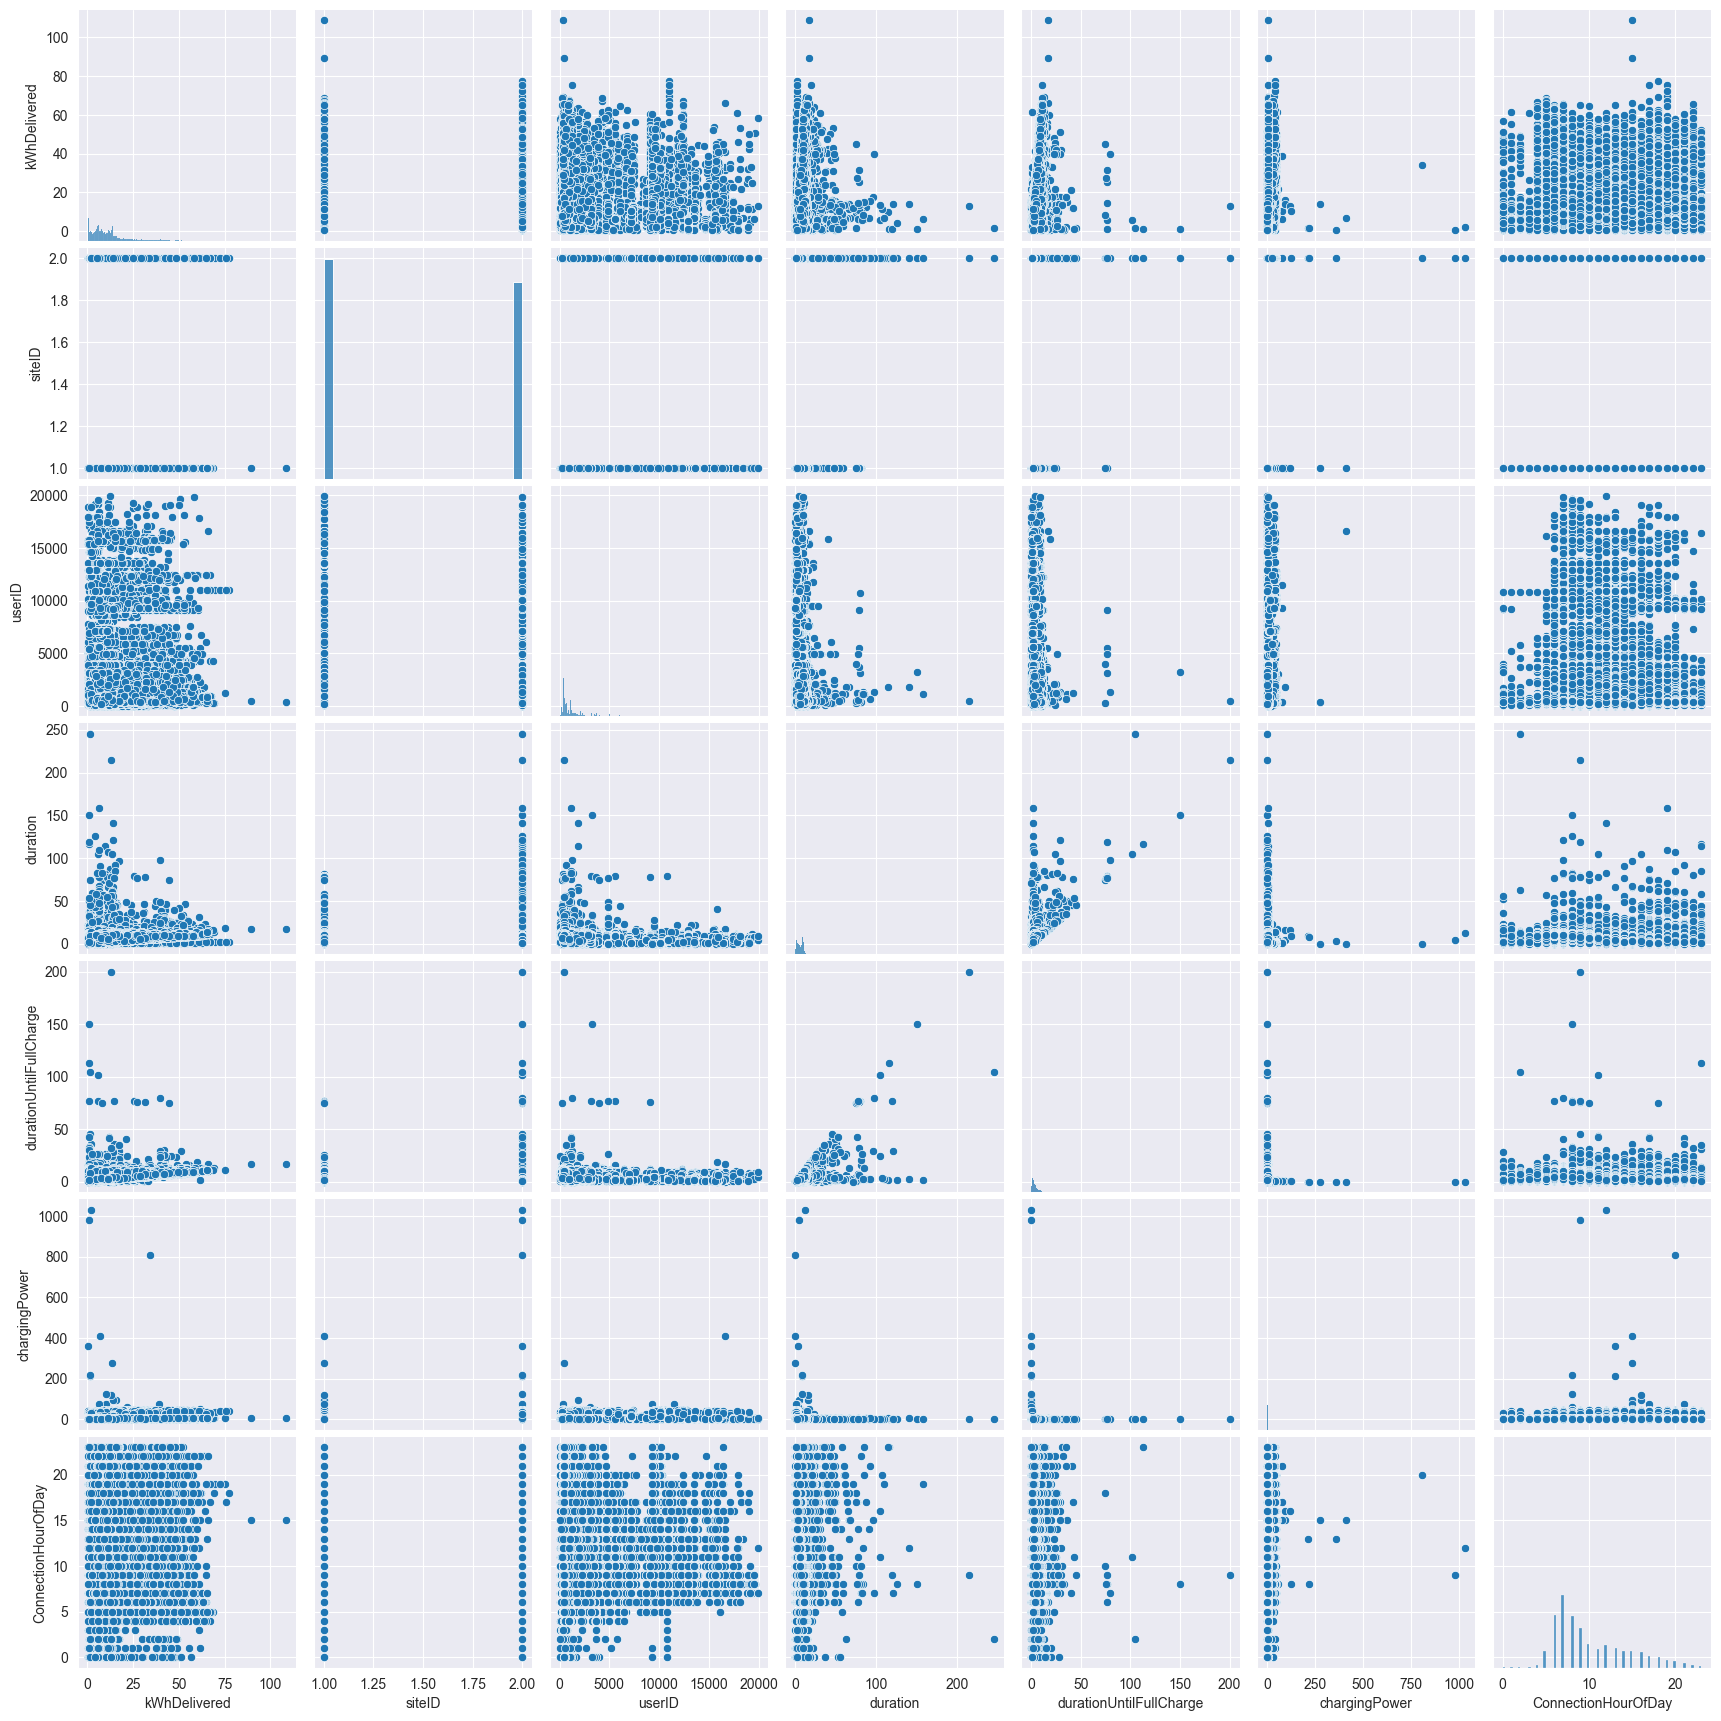

In [49]:
sns.pairplot(data=features)


In [29]:
droppedfeatures = features.drop(columns=['userInputs','connectionTime','disconnectTime','doneChargingTime']).dropna()
droppedfeatures.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49187 entries, 0 to 66448
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   kWhDelivered         49187 non-null  float64
 1   siteID               49187 non-null  int64  
 2   userID               49187 non-null  float64
 3   duration             49187 non-null  float64
 4   ConnectionHourOfDay  49187 non-null  int32  
dtypes: float64(3), int32(1), int64(1)
memory usage: 2.1 MB


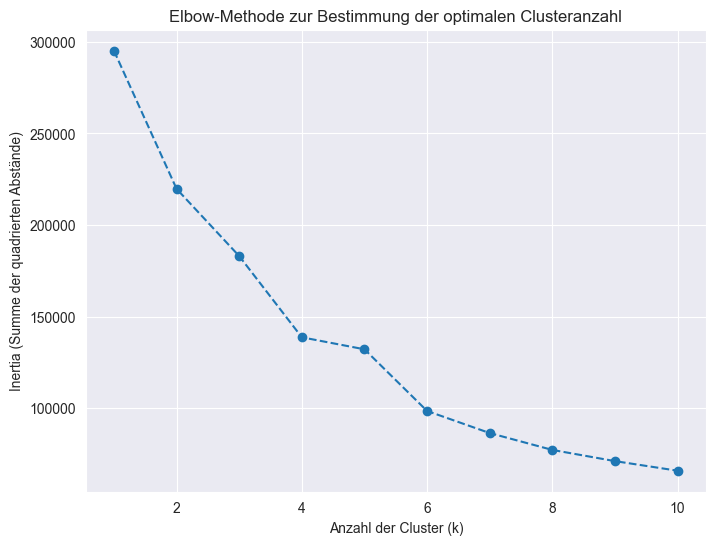

In [50]:

scaler = StandardScaler()
scaled_features = scaler.fit_transform(droppedfeatures)


# 5. Elbow-Methode zur Bestimmung der optimalen Anzahl von Clustern
inertia = []
cluster_range = range(1, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Elbow-Plot erstellen
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia, marker='o', linestyle='--')
plt.title("Elbow-Methode zur Bestimmung der optimalen Clusteranzahl")
plt.xlabel("Anzahl der Cluster (k)")
plt.ylabel("Inertia (Summe der quadrierten Abstände)")
plt.grid(True)
plt.show()


Cluster-Zentren (5 Cluster):
Cluster 1:
  Gelieferte Energie = 16.13 kWh
  Ladezeit = 1.01 Stunden
  Stunde des Tages = 1190.51
  Standort-ID = 8.68

Cluster 2:
  Gelieferte Energie = 11.05 kWh
  Ladezeit = 1.00 Stunden
  Stunde des Tages = 1420.40
  Standort-ID = 3.37

Cluster 3:
  Gelieferte Energie = 17.19 kWh
  Ladezeit = 1.00 Stunden
  Stunde des Tages = 9876.42
  Standort-ID = 6.06

Cluster 4:
  Gelieferte Energie = 10.50 kWh
  Ladezeit = 2.00 Stunden
  Stunde des Tages = 1157.93
  Standort-ID = 5.75

Cluster 5:
  Gelieferte Energie = 14.94 kWh
  Ladezeit = 2.00 Stunden
  Stunde des Tages = 10979.94
  Standort-ID = 3.19



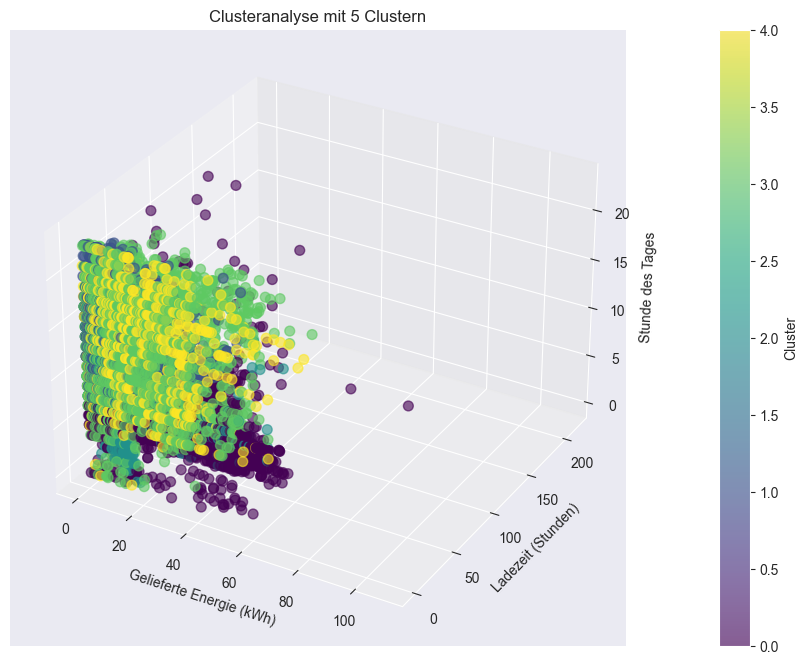

In [52]:
# 6. Clusteranalyse mit der optimalen Anzahl von Clustern
# Benutzer kann die optimale Anzahl der Cluster auswählen
optimal_k = int(input("Gib die optimale Anzahl der Cluster (k) ein: "))
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
droppedfeatures['cluster'] = kmeans.fit_predict(scaled_features)

# Cluster-Zentren zurückskalieren
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)

# Cluster-Zentren ausgeben
print(f"\nCluster-Zentren ({optimal_k} Cluster):")
for i, center in enumerate(cluster_centers):
    print(f"Cluster {i + 1}:")
    print(f"  Gelieferte Energie = {center[0]:.2f} kWh")
    print(f"  Ladezeit = {center[1]:.2f} Stunden")
    print(f"  Stunde des Tages = {center[2]:.2f}")
    print(f"  Standort-ID = {center[3]:.2f}")
    print()



# 7. Grafische Darstellung der Clusteranalyse
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    droppedfeatures['kWhDelivered'],
    droppedfeatures['duration'],
    droppedfeatures['ConnectionHourOfDay'],
    c=droppedfeatures['cluster'], cmap='viridis', s=50, alpha=0.6
)

# Achsen beschriften
ax.set_xlabel("Gelieferte Energie (kWh)")
ax.set_ylabel("Ladezeit (Stunden)")
ax.set_zlabel("Stunde des Tages")
ax.set_title(f"Clusteranalyse mit {optimal_k} Clustern")

# Farbskala hinzufügen
cbar = plt.colorbar(scatter, pad=0.1, ax=ax)
cbar.set_label("Cluster")

plt.show()

In [40]:
cluster_size = scaled_features.groupby('cluster').size()
cluster_size

cluster
0.00    17479
0.25     8904
0.50     5853
0.75    14179
1.00     2772
dtype: int64

In [24]:
# fuzzy c means
import skfda
from skfda.ml.clustering import FuzzyCMeans


# preprocess for this specific module
X_f = skfda.FDataGrid(features)

fuzzy_model = skfda.ml.clustering.FuzzyCMeans(n_clusters=3)


ImportError: cannot import name 'RandomStateLike' from 'skfda._utils' (C:\Users\maximilian.j.mueller\PycharmProjects\AAEnergizer\.venv1\Lib\site-packages\skfda\_utils\__init__.py)

In [53]:
import skfda
data_matrix = [[[1, 0.3], [2, 0.4], [3, 0.5], [4, 0.6]],
               [[2, 0.5], [3, 0.6], [4, 0.7], [5, 0.7]],
               [[3, 0.2], [4, 0.3], [5, 0.4], [6, 0.5]]]
grid_points = [2, 4, 6, 8]
fd = skfda.FDataGrid(data_matrix, grid_points)
fuzzy_kmeans = skfda.ml.clustering.FuzzyCMeans(random_state=0)
fuzzy_kmeans.fit(fd)
FuzzyCMeans(...)
fuzzy_kmeans.cluster_centers_.data_matrix

ImportError: cannot import name '_check_array_key' from 'skfda._utils' (C:\Users\maximilian.j.mueller\PycharmProjects\AAEnergizer\.venv1\Lib\site-packages\skfda\_utils\__init__.py)